In [1]:
import calour as ca
import calour_utils as cu

failed to load logging config file


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import numpy as np
import matplotlib as mpl
import pandas as pd
import scipy as sp;
from collections import defaultdict

In [3]:
pwd

'/Users/amnon/git/paper-daycare'

In [4]:
ca.set_log_level(11)

In [5]:
%matplotlib inline

In [6]:
db=ca.database._get_database_class('dbbact')

creating logger


# Load the data

In [45]:
gan = ca.read_amplicon('data/gan-normalized.biom', 'data/gan-normalized_sample.txt', min_reads=10, normalize=100)

2021-10-04 15:40:29 INFO loaded 268 samples, 928 features
2021-10-04 15:40:29 WARNING Do you forget to normalize your data? It is required before running this function
2021-10-04 15:40:29 INFO After filtering, 268 remain.


# What we have

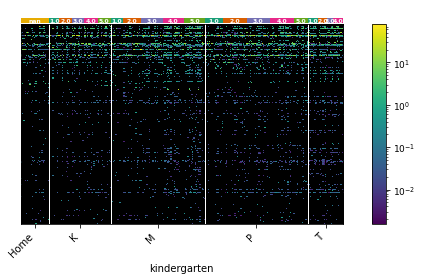

In [20]:
gan.plot(sample_field='kindergarten',barx_fields=['Time'])

# Find "twins" (children with similar age) in same and different kindergartens

In [21]:
def find_twins(exp,timepoint=None, cutoff=1):
    '''for each participant find twins with age < cutoff difference
    
    Parameters
    ----------
    exp: calour.Experiment
        the experiment to process
    timepoint: str or None, optional
        if not None, process only the given timepoint in the experiment
    cutoff: float, optional
        the similarity threshold (in months) for twins
    
    Returns
    -------
    twins: dict of list
        key is twin sample_id, list is list of twin sample_ids identified for each subject
    stwins: dict of list
        similar to twins, but only for twins from same kindergarten
    dtwins: dict of list
        similar to twins, but only for twins from different kindergarten
    '''
    if timepoint is not None:
        exp=exp.filter_samples('Time',timepoint)
    twins=defaultdict(list)
    stwins=defaultdict(list)
    dtwins=defaultdict(list)
    sd = exp.sample_metadata
    print('processing %d unique ids for timepoint %s' % (len(sd['pn_ID'].unique()), timepoint))
    for id1 in sd['pn_ID'].unique():
        cv1 = sd[sd['pn_ID']==id1]
        if len(cv1)>1:
            print('more than 1 sample for individual %s. skipping' % id1)
            continue
        for id2 in sd['pn_ID'].unique():
            # skip if same individual
            if id1==id2:
                continue
            cv2 = sd[sd['pn_ID']==id2]
            if len(cv2)>1:
                print('more than 1 sample for individual %s. skipping' % id2)
                continue
            age1 = cv1['age_months'].values[0]
            age2 = cv2['age_months'].values[0]
            gan1 = cv1['kindergarten'].values[0]
            gan2 = cv2['kindergarten'].values[0]
            ind1 = cv1['_sample_id'].values[0]
            ind2 = cv2['_sample_id'].values[0]
            if np.abs(age1-age2)<cutoff:
                twins[ind1].append(ind2)
                if gan1 == gan2:
                    stwins[ind1].append(ind2)
                else:
                    dtwins[ind1].append(ind2)
            else:
                pass
    print('found %d samples with twins' % len(twins))
    print('found %d from same gan' % len(stwins))
    print('found %d from different gan' % len(dtwins))
    return twins, stwins, dtwins

In [22]:
def get_bj_dist(exp,ind1,ind2,thresh=0.01):
    '''Calculate the binary-jaccard distance (not similarity) for 2 samples.
    Defined as 1- ( size(intersection(S1,S2) / size(union(S1,S2) ) )

    Parameters
    ----------
    exp: calour.Experiment
        the experiment to process
    int1, ind2: int
        the sample_ids for the 2 samples
    thresh: float, optional
        the minimal percent of reads to consider the feature present
        (since binary-jaccard looks at absence/presence)
    
    Returns
    -------
    dist: float
        the binary jaccard distance between the 2 samples
    '''
    sd=exp.sample_metadata
    dat=exp.get_data(sparse=False)
    v1=dat[sd.index.get_loc(ind1),:]
    v2=dat[sd.index.get_loc(ind2),:]
    v1 = v1>=thresh
    v2 = v2>=thresh
    dist = 1 - np.sum(np.logical_and(v1,v2))/(np.sum(np.logical_or(v1,v2)))
    return dist
    

In [26]:
def get_bc_dist(exp,ind1,ind2):
    '''Calculate the bray-curtis distance (not similarity) for 2 samples.
    Defined as abs(S1-S2) / ( S1+S2 ) )

    Parameters
    ----------
    exp: calour.Experiment
        the experiment to process
    int1, ind2: int
        the sample_ids for the 2 samples
    
    Returns
    -------
    dist: float
        the binary jaccard distance between the 2 samples'''
    sd=exp.sample_metadata
    dat=exp.get_data(sparse=False)
    v1=dat[sd.index.get_loc(ind1),:]
    v2=dat[sd.index.get_loc(ind2),:]
    dist = np.sum(np.abs(v1-v2))/np.sum(v1+v2)
    return dist


In [48]:
def twins_dist(exp, timepoint, cutoff=1, method='bj'):
    '''Plot the distance histogram for same and different kindergarten twins
    
    Parameters
    ----------
    exp: calour.Experiment
        The experiment to process
    timepoint: int
        the timepoint to process (1-5)
    cutoff: float, optional
        the maximal age difference (months) between 2 individuals to be called "twins"
    method: str, optional
        The distance calculation method. options:
        'bj' - binary jaccard
        'bc' - bray curtis
    '''
    twins,stwins,dtwins=find_twins(exp,timepoint, cutoff)
    tt=exp.filter_samples('Time', timepoint)

    # same daycare twins distances
    sdist=[]
    for id1,allid2 in stwins.items():
        for id2 in allid2:
            # consider each twins pair only once
            if id2 < id1:
                continue
            if method == 'bj':
                sdist.append(get_bj_dist(tt,id1,id2)) 
            elif method == 'bc':
                sdist.append(get_bc_dist(tt,id1,id2)) 
            else:
                raise ValueError('method %s not supported' % method)

    # different daycare twins distances
    ddist=[]
    for id1,allid2 in dtwins.items():
        for id2 in allid2:
            # consider each twins pair only once
            if id2 < id1:
                continue
            if method == 'bj':
                ddist.append(get_bj_dist(tt,id1,id2)) 
            elif method == 'bc':
                ddist.append(get_bc_dist(tt,id1,id2)) 
            else:
                raise ValueError('method %s not supported' % method)
    
    f=plt.figure()
    _=plt.hist(ddist,10,alpha=1)
    _=plt.hist(sdist,10,alpha=1)
    plt.title('timepoint %s' % timepoint)
    plt.legend(['different','same'])
    plt.ylabel('number of twins')
    plt.xlabel('binary jaccard distance')
    print('mean (median) distance same gan twins: %f (%f)' % (np.mean(sdist), np.median(sdist)))
    print('mean (median) distance different gan twins: %f (%f)' % (np.mean(ddist), np.median(ddist)))
    print('mann whitney p-val: %f' % scipy.stats.mannwhitneyu(ddist,sdist)[1])
    plt.title('timepoint %s same: %f, different: %f, p-val %f' % (timepoint, np.mean(sdist), np.mean(ddist), scipy.stats.mannwhitneyu(ddist,sdist)[1]))
    return f

# Calculate the Binary-Jaccard distances

processing 41 unique ids for timepoint 1
found 39 samples with twins
found 35 from same gan
found 26 from different gan
mean (median) distance same gan twins: 0.764299 (0.777778)
mean (median) distance different gan twins: 0.785002 (0.782178)
mann whitney p-val: 0.148446


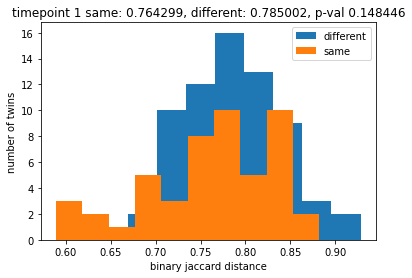

In [49]:
f=twins_dist(gan,timepoint=1,cutoff=1)
f.savefig('figures/twins-time1.pdf')

processing 54 unique ids for timepoint 2
found 52 samples with twins
found 49 from same gan
found 46 from different gan
mean (median) distance same gan twins: 0.727419 (0.729167)
mean (median) distance different gan twins: 0.770747 (0.772329)
mann whitney p-val: 0.000067


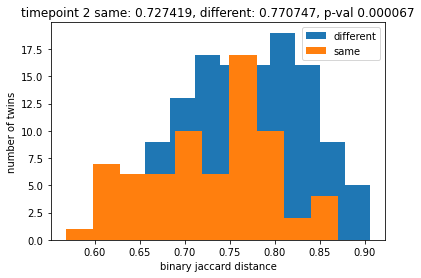

In [50]:
f=twins_dist(gan,timepoint=2,cutoff=1)
f.savefig('figures/twins-time2.pdf')

processing 52 unique ids for timepoint 3
found 50 samples with twins
found 44 from same gan
found 44 from different gan
mean (median) distance same gan twins: 0.708685 (0.695563)
mean (median) distance different gan twins: 0.762990 (0.768293)
mann whitney p-val: 0.000000


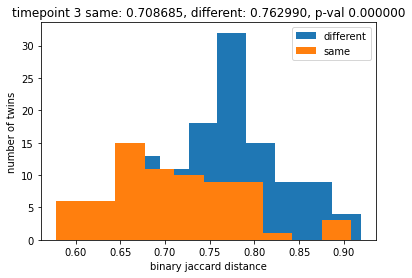

In [51]:
f=twins_dist(gan,timepoint=3,cutoff=1)
f.savefig('figures/twins-time3.pdf')

processing 57 unique ids for timepoint 4
found 55 samples with twins
found 50 from same gan
found 45 from different gan
mean (median) distance same gan twins: 0.686745 (0.692459)
mean (median) distance different gan twins: 0.747605 (0.747368)
mann whitney p-val: 0.000000


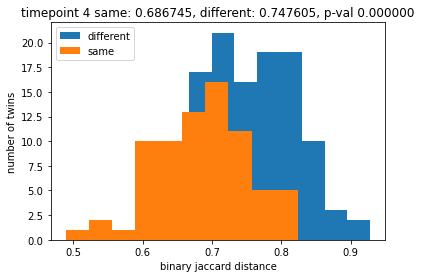

In [52]:
f=twins_dist(gan,timepoint=4,cutoff=1)
f.savefig('figures/twins-time4.pdf')

processing 40 unique ids for timepoint 5
found 38 samples with twins
found 34 from same gan
found 36 from different gan
mean (median) distance same gan twins: 0.708233 (0.704548)
mean (median) distance different gan twins: 0.749457 (0.733207)
mann whitney p-val: 0.001108


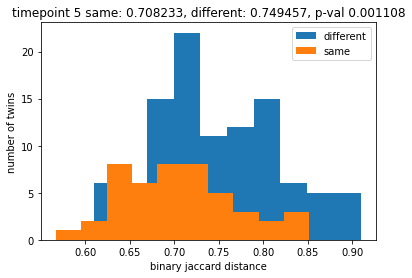

In [53]:
f=twins_dist(gan,timepoint=5,cutoff=1)
f.savefig('figures/twins-time5.pdf')

# And the Bray-Curtis Distances

processing 41 unique ids for timepoint 1
found 39 samples with twins
found 35 from same gan
found 26 from different gan
mean (median) distance same gan twins: 0.815295 (0.826938)
mean (median) distance different gan twins: 0.811733 (0.829152)
mann whitney p-val: 0.473874


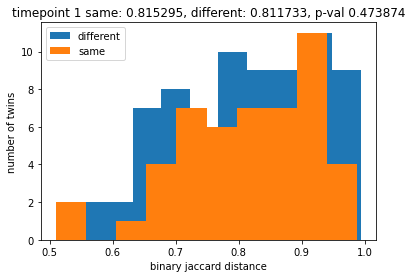

In [62]:
f=twins_dist(gan,timepoint=1,cutoff=1,method='bc')
f.savefig('supplementary/twins-time1-bc.pdf')

processing 54 unique ids for timepoint 2
found 52 samples with twins
found 49 from same gan
found 46 from different gan
mean (median) distance same gan twins: 0.749356 (0.790258)
mean (median) distance different gan twins: 0.817525 (0.838048)
mann whitney p-val: 0.001414


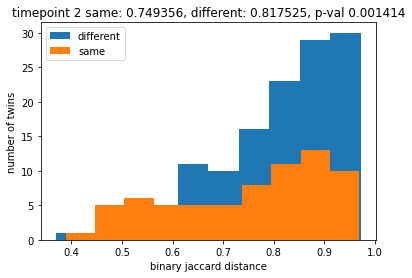

In [63]:
f=twins_dist(gan,timepoint=2,cutoff=1,method='bc')
f.savefig('supplementary/twins-time2-bc.pdf')

processing 52 unique ids for timepoint 3
found 50 samples with twins
found 44 from same gan
found 44 from different gan
mean (median) distance same gan twins: 0.725109 (0.742580)
mean (median) distance different gan twins: 0.785737 (0.809283)
mann whitney p-val: 0.001410


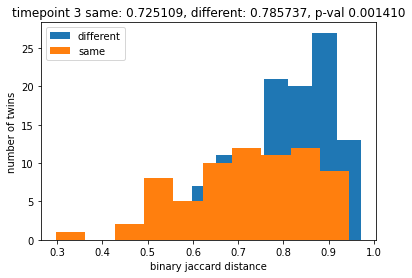

In [64]:
f=twins_dist(gan,timepoint=3,cutoff=1,method='bc')
f.savefig('supplementary/twins-time3-bc.pdf')

processing 57 unique ids for timepoint 4
found 55 samples with twins
found 50 from same gan
found 45 from different gan
mean (median) distance same gan twins: 0.741722 (0.772896)
mean (median) distance different gan twins: 0.801317 (0.848214)
mann whitney p-val: 0.000221


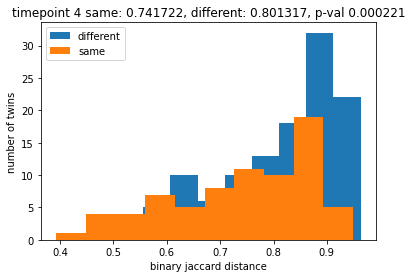

In [60]:
f=twins_dist(gan,timepoint=4,cutoff=1,method='bc')
f.savefig('supplementary/twins-time4-bc.pdf')

processing 40 unique ids for timepoint 5
found 38 samples with twins
found 34 from same gan
found 36 from different gan
mean (median) distance same gan twins: 0.762092 (0.777540)
mean (median) distance different gan twins: 0.787667 (0.808101)
mann whitney p-val: 0.057943


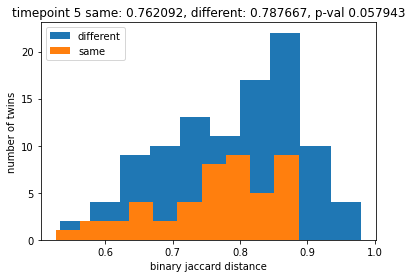

In [61]:
f=twins_dist(gan,timepoint=5,cutoff=1,method='bc')
f.savefig('supplementary/twins-time5-bc.pdf')